# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 17th of february at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "kenza"
ln1 = "benjelloun"
fn2 = "matthieu"
ln2 = "dubois"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_benjelloun_kenza_and_dubois_matthieu.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [ ]:
%matplotlib inline

In [ ]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [ ]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [ ]:
print(numba.__version__) # Your version of Numba

0.56.4


In [ ]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [ ]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [ ]:
%timeit go_fast(x)

2.25 µs ± 924 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [ ]:
%timeit go_fast.py_func(x)

42.2 µs ± 4.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [ ]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [ ]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [ ]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [ ]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [ ]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


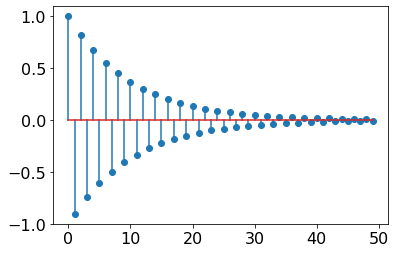

In [ ]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [ ]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.6036012088863039e-06

In [ ]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.003401499612298e-07

### Choice of the model

In [ ]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [ ]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06129365667049995


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5306219277710231
1.553796983582191e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD)

### Define a class to monitor iterations

In [ ]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [ ]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [ ]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step * grad(x,args[0],args[1],args[2])

        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [ ]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_k = y - step * grad(y,args[0],args[1],args[2])
        t_k = (1 + (1 + 4 * t**2 ) **0.5)/2
        y = x_k + (t - 1)*(x_k - x)/(t_k)
        x = x_k
        t = t_k
    return x, x_list

In [ ]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [ ]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)

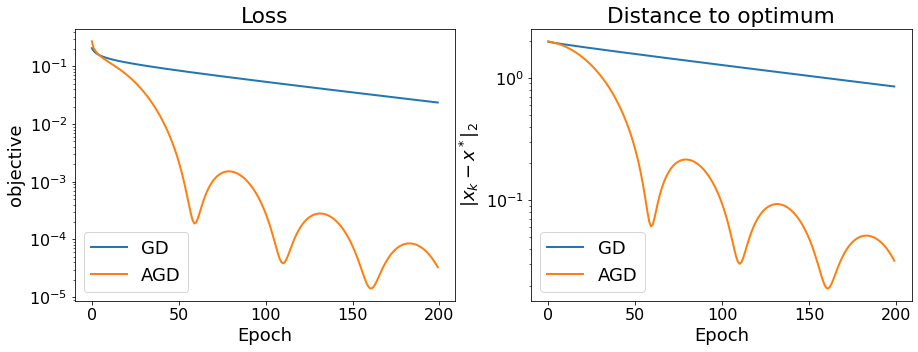

In [ ]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

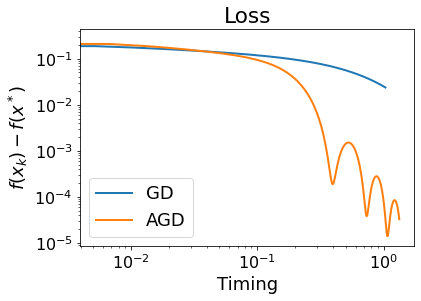

In [ ]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

- AGD performs better than GD but it takes slightly longer to execute. 
- It is expected of AGD to perform better and take longer as it calculates 3 values instead of one. The shape of the curves is also expected as AGD first makes a big jump in the direction of the previous accumulated gradient and then measures the gradient where it ends up and makes a correction.

<a id='stoc'></a> 
## 4. Stochastic methods

In [ ]:
#n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [ ]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        x = x - step * grad_i(i,x,args[0],args[1],args[2]) / (idx+1)**0.5

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [ ]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        g_i_t = grad_i(i,x,args[0],args[1],args[2])
        averaged_gradient = averaged_gradient + (g_i_t - gradient_memory[i])/n
        gradient_memory[i] = g_i_t
        x = x - step * averaged_gradient
        

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

# SVRG with first method (takes too long)

In [ ]:
from numba import objmode
from time import time
from time import perf_counter

In [ ]:
@njit
def svrg1(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    with objmode(time1='f8'):
        time1 = perf_counter()

    for idx in range(n_iter):

  
        ### TODO     
                
        mu = grad(x_old, args[0], args[1], args[2])
        x = x_old.copy()
        with objmode() :
          print('time first loop: {}'.format(perf_counter() - time1))

        for t in range(n):
          i = random_indices[t]
          with objmode():
            curr = time()
          x = x - step * (grad_i(i,x,args[0], args[1], args[2]) - grad_i(i,x_old, args[0], args[1], args[2]) + mu)
          
        x_old = x.copy()

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
'''x_init = np.zeros(d)
monitor_svrg1 = monitor(svrg1, loss, x_min, (A, b ,lbda))
monitor_svrg1.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))'''

'x_init = np.zeros(d)\nmonitor_svrg1 = monitor(svrg1, loss, x_min, (A, b ,lbda))\nmonitor_svrg1.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))'

We noticed that this method was taking too long, so we tried showing how long it took for one loop to be executed, the first loop keeps running for more than n_iter time, and we can't point out why (we'd expect n_iter= 200 iterations). So we used the second methode given in class by the teacher.

# SVRG with second method (quick)

In [ ]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []

    for idx in range(n_iter):
      i = random_indices[idx]
      if idx % n == 0:
            x_old = x
            mu = grad(x_old,args[0],args[1],args[2])
            
      x = x - step*(grad_i(i,x,args[0],args[1],args[2])-grad_i(i,x_old,args[0],args[1],args[2])+mu)
      
        # Update metrics after each iteration.
      if idx % store_every == 0:
          x_list.append(x.copy())
    return x, x_list

In [ ]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

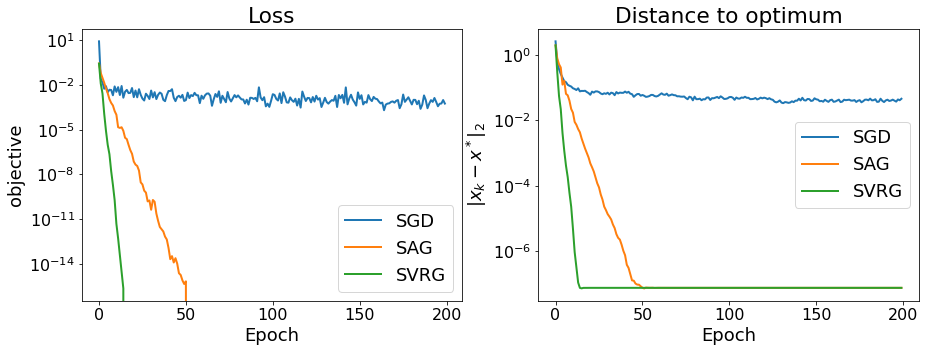

In [ ]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

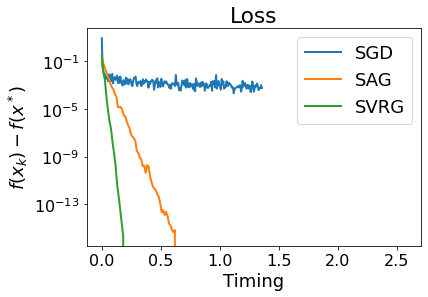

In [ ]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

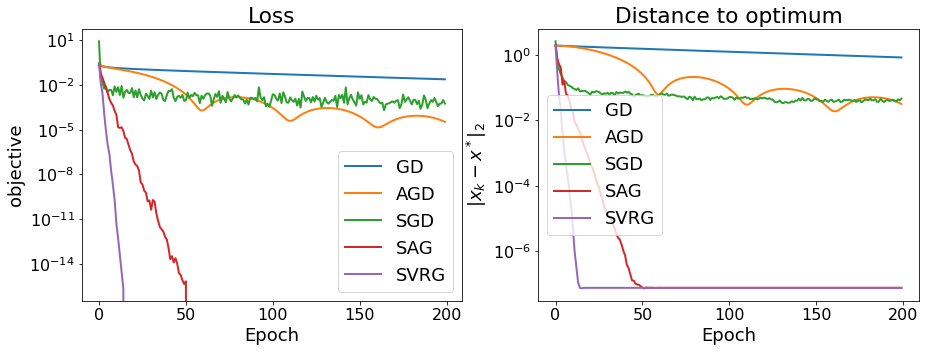

In [ ]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

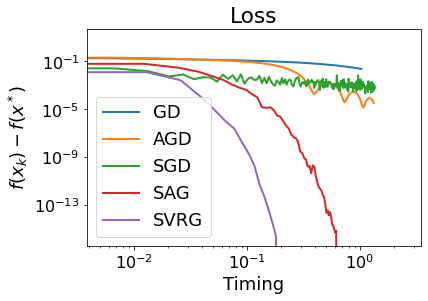

In [ ]:
plot_time(monitors, solvers, xscale='log')

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude


**Compare and comment your results :**

- SAG and SVRG have a linear convergence, but SGD ends up oscillating around a value far from the minimum.
- SAG is faster than SGD and is clearly reaching a closer value to the minimum, however they both have unstable loss curves. 
- SVRG seems to perform the best out of all methods. 


**Change the value of the ridge regularization (the lbda parameter) to low ridge  λ=1/n  and high ridge regularization  λ=1  and compare your results. Comment.**

In [ ]:
def get_monitors(lbda , corr=0.9, model='linreg'): 
  #init

    if model== 'linreg': 
        A, b = simu_linreg(x_model_truth, n, std=1., corr=corr)
        loss = loss_linreg
        grad = grad_linreg
        grad_i = grad_i_linreg
        lipschitz_constant = lipschitz_linreg
    elif model=='logreg': 
        A, b = simu_logreg(x_model_truth, n, std=1., corr=corr)
        loss = loss_logreg
        grad = grad_logreg
        grad_i = grad_i_logreg
        lipschitz_constant = lipschitz_logreg


    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

    #GD
    step = 1. / lipschitz_constant(A, b, lbda)
    monitor_gd= monitor(gd, loss, x_min, (A, b ,lbda))
    monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))


    # AGD
    step = 1. / lipschitz_constant(A, b, lbda)
    x_init = np.zeros(d)
    monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
    monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))


    # SGD
    step0 = 1e-1
    x_init = np.zeros(d)
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, random_indices, grad_i, n_iter*n , step0, args=(A, b, lbda))

    # SAG
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    step = 1.0 / (max_squared_sum + lbda)
    monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
    monitor_sag.run(x_init, random_indices, grad_i, n_iter *n, step, args=(A, b, lbda))

    # SVRG
    x_init = np.zeros(d)
    monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
    monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))
   
    # monitors
    monitors= [monitor_gd, monitor_agd, monitor_sgd, monitor_sag, monitor_svrg]
    return monitors


# Linear Regression - Low Ridge




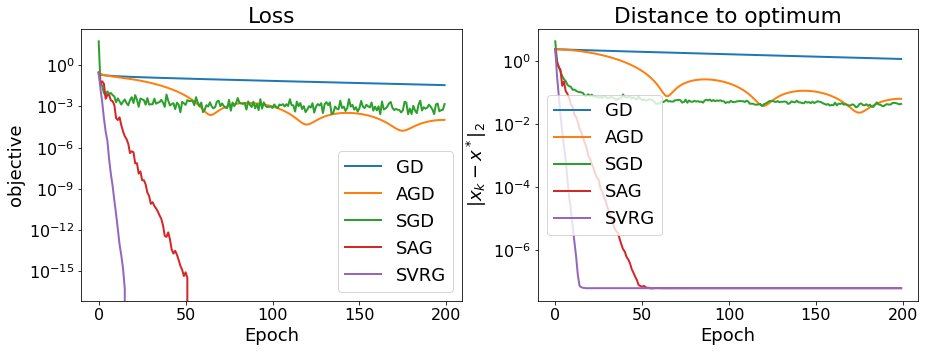

In [ ]:
monitors = get_monitors(lbda=1./n, corr=0.9, model='linreg')
solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]
plot_epochs(monitors , solvers)


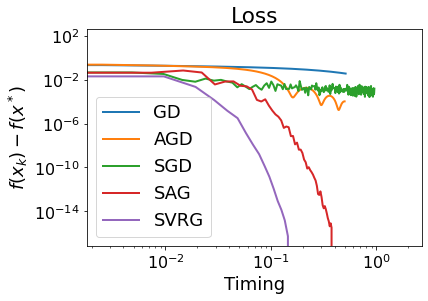

In [ ]:
plot_time(monitors, solvers, xscale='log')

# Linear Regression -  High Ridge




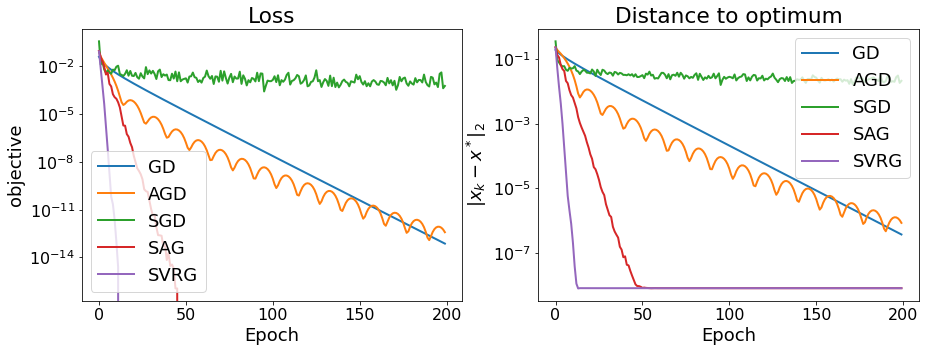

In [ ]:
monitors = get_monitors(lbda=1, corr=0.9, model='linreg')
plot_epochs(monitors , solvers)

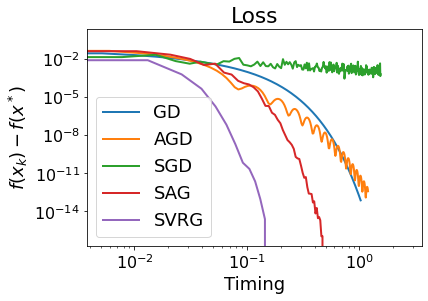

In [ ]:
plot_time(monitors, solvers, xscale='log')

# Logistic Regression - Low Ridge

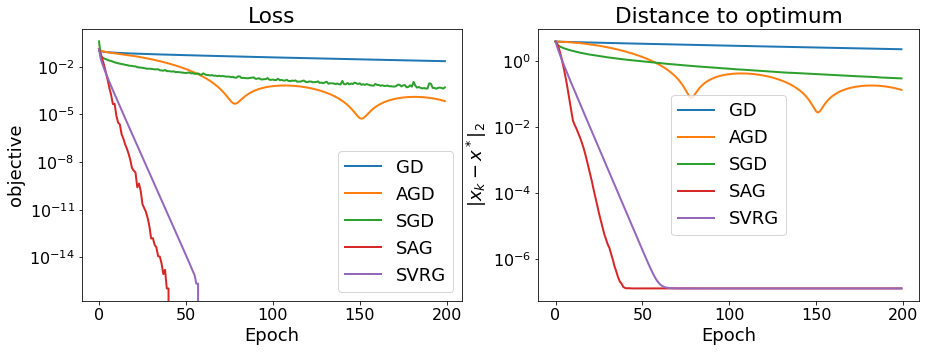

In [ ]:
monitors = get_monitors(lbda=1./n, corr=0.9, model='logreg')
solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]
plot_epochs(monitors , solvers)


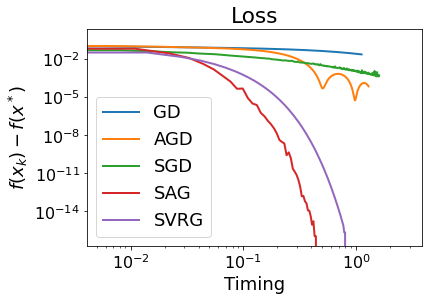

In [ ]:
plot_time(monitors, solvers, xscale='log')

# Logistic Regression -  High Ridge






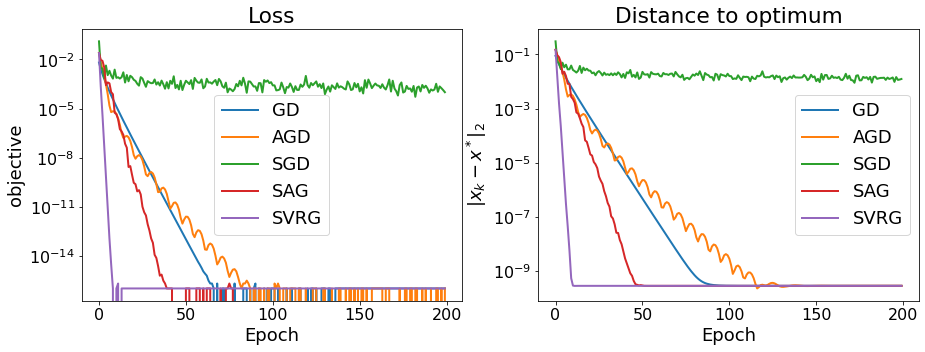

In [ ]:
monitors = get_monitors(lbda=1, corr=0.9, model='logreg')
plot_epochs(monitors , solvers)

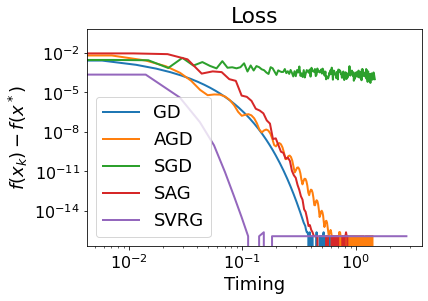

In [ ]:
plot_time(monitors, solvers, xscale='log')

**Comments :**
- SVRG is slower under low ridge regularization 
- AGD bounds get smaller under high ridge regularization 
- SAG convergs quicker than SVRG under low ridge regularization for logistic rgression 
- SGD doesn't seem to be particularly affected by these changes 

In [ ]:
def plot_epochs_and_time(monitors, solvers, corr, xscale='linear', yscale='log', ):
    plt.figure(figsize=(20, 5))
    plt.suptitle("Correlation = " + str(corr), fontsize=20)
    plt.subplot(1, 3, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 3, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)

    plt.subplot(1,3,3)
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss" )
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)
    


# Linear Regression - Different Correlations 

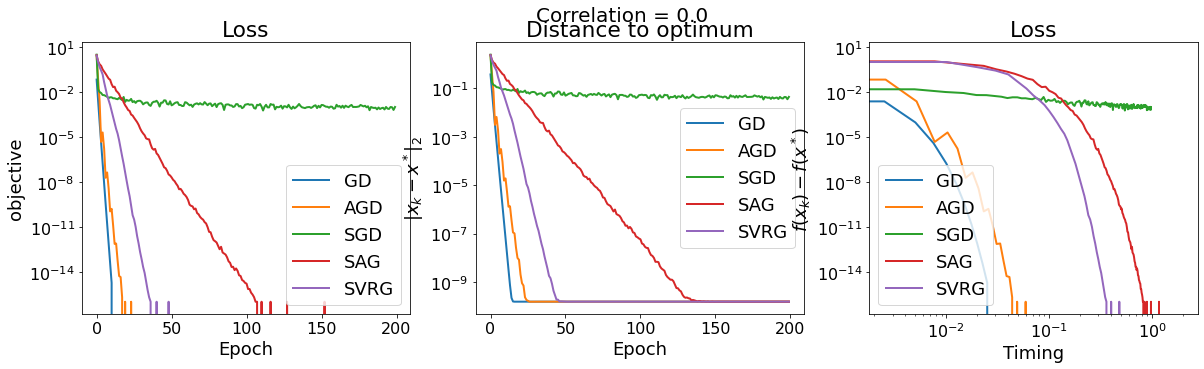

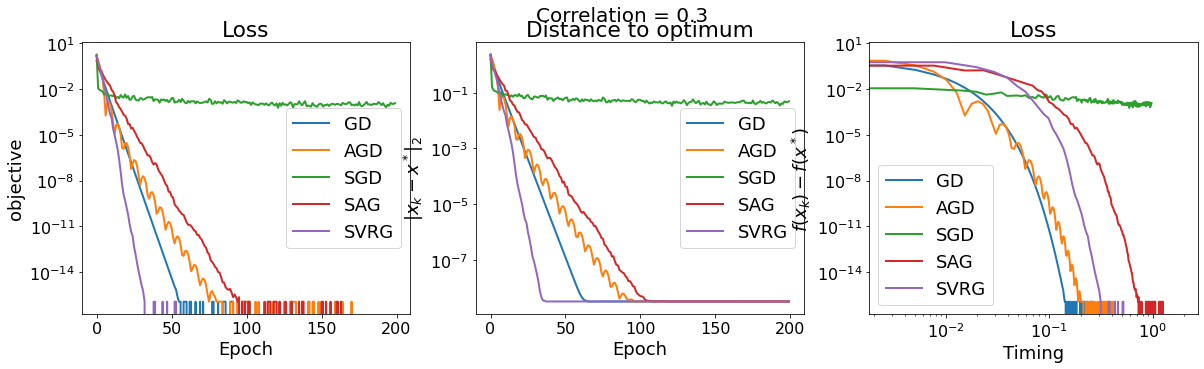

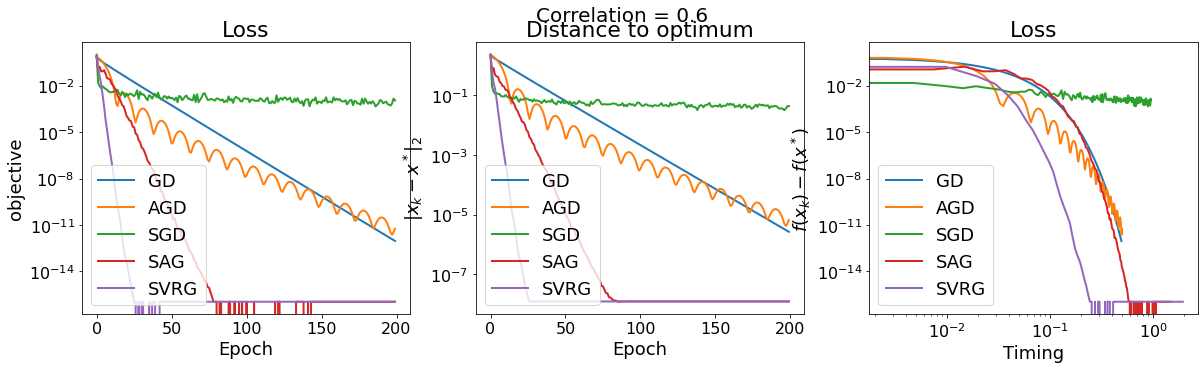

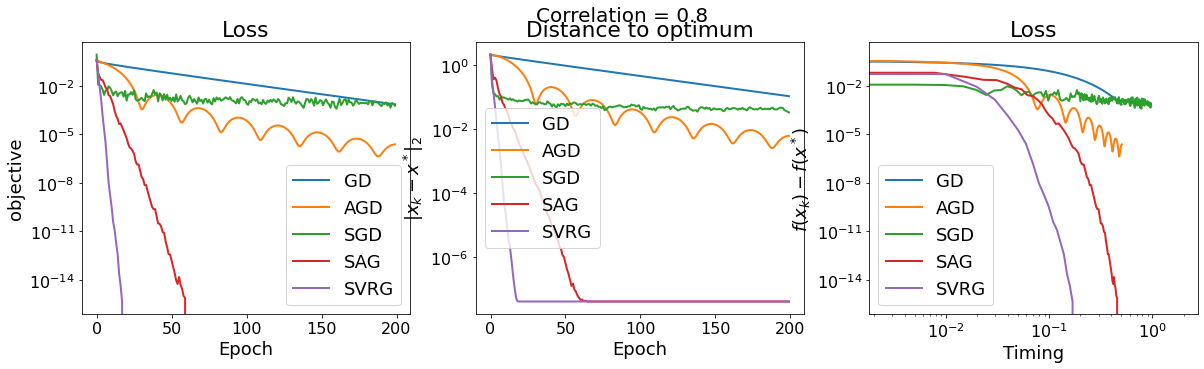

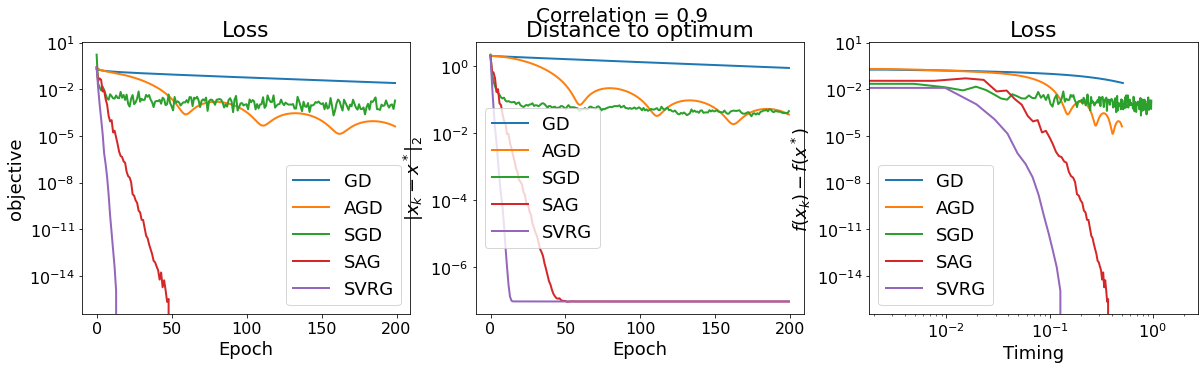

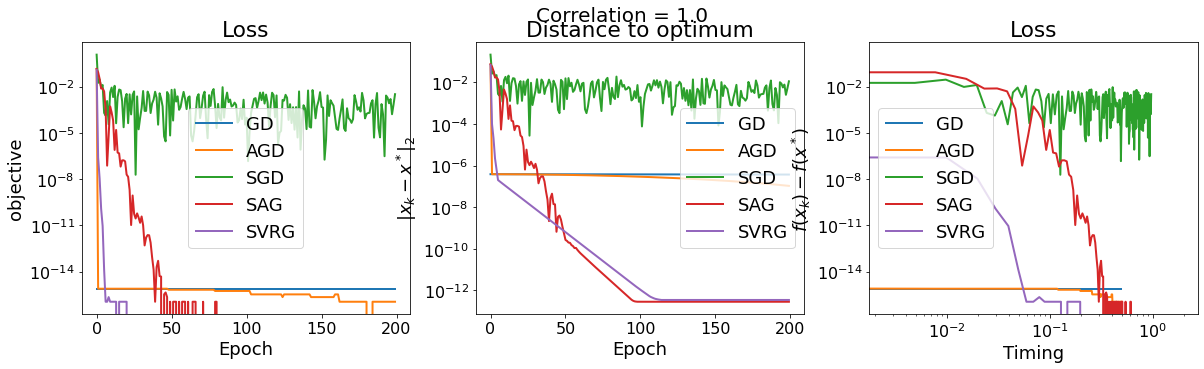

In [ ]:
for corr in  [0.,0.3,0.6,0.8,0.9,1.0] :
  monitors = get_monitors(lbda = 1. / n ** (0.5), corr=corr, model='linreg')
  solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]
  plot_epochs_and_time(monitors, solvers, xscale = 'log', corr = corr)
  


# Logistic Regression - Different Correlations 

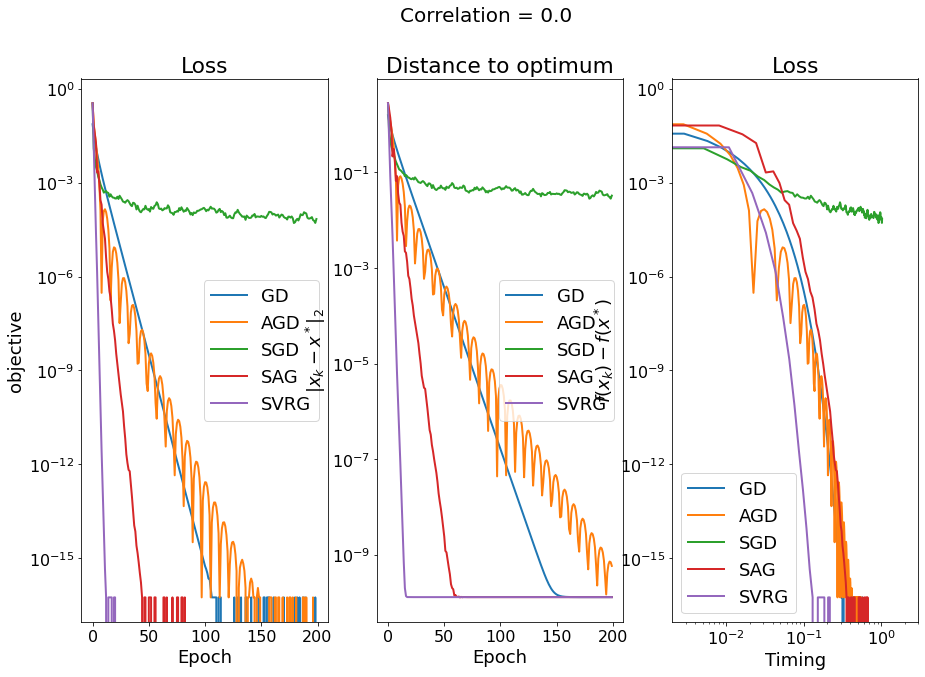

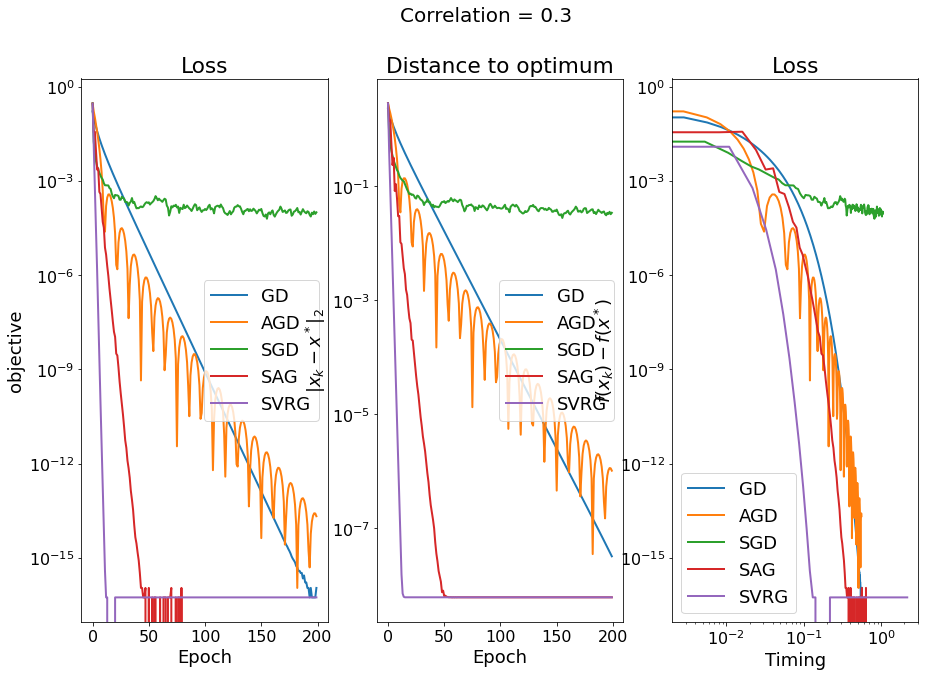

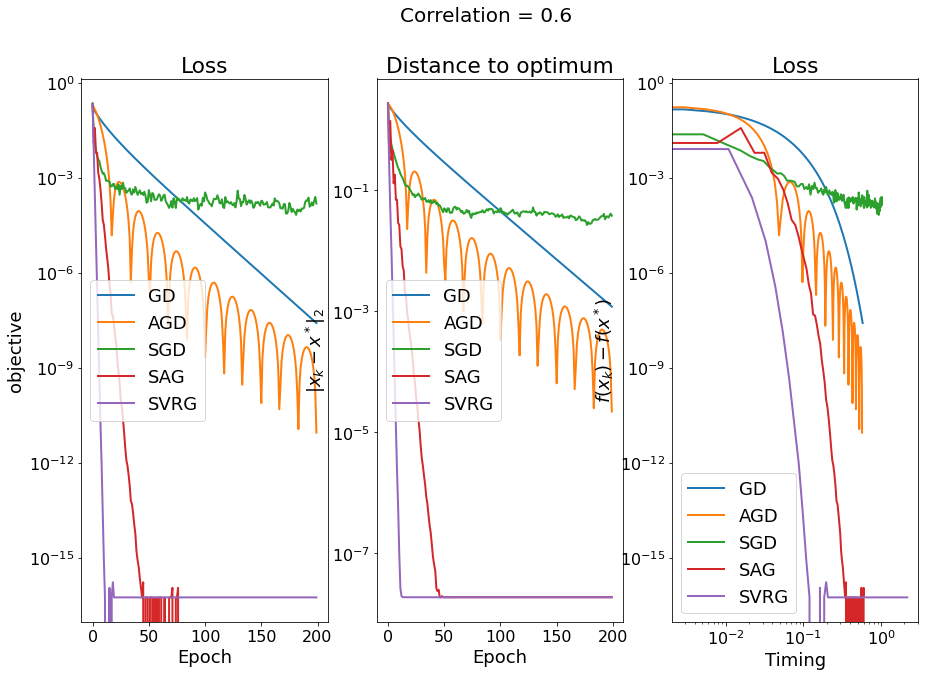

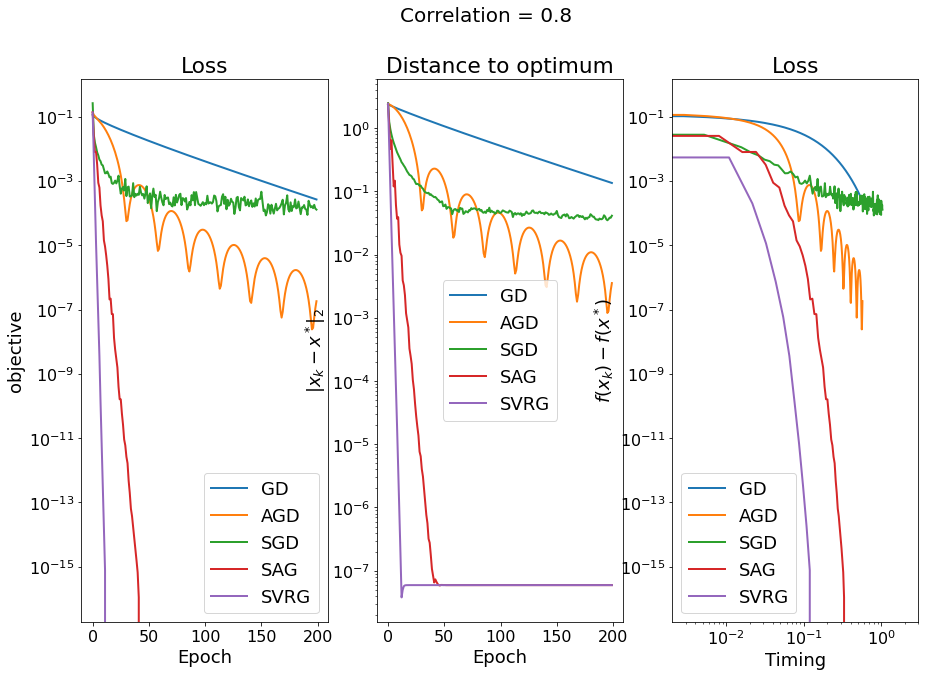

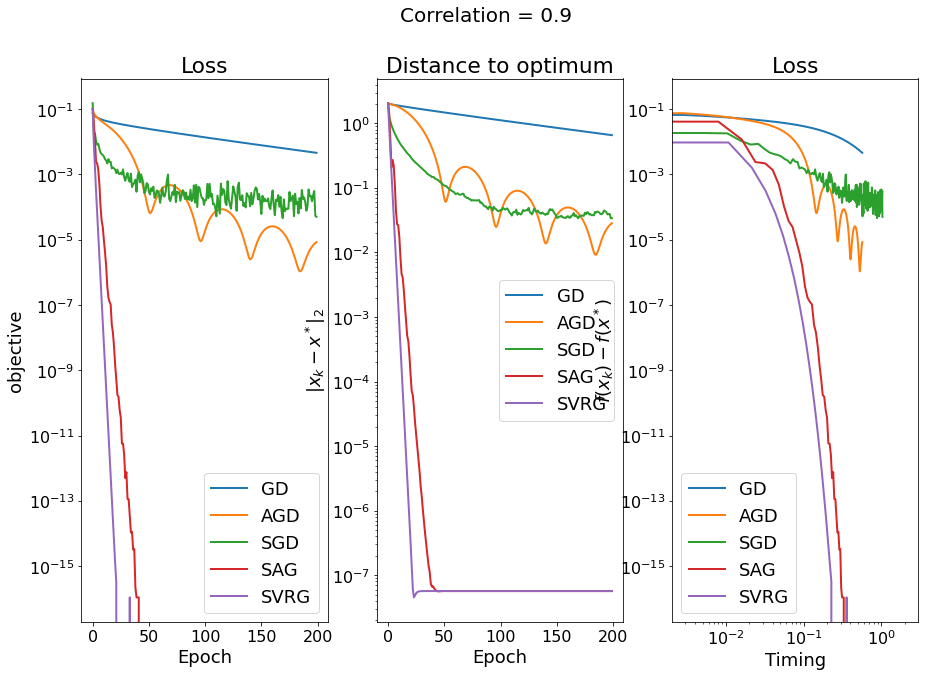

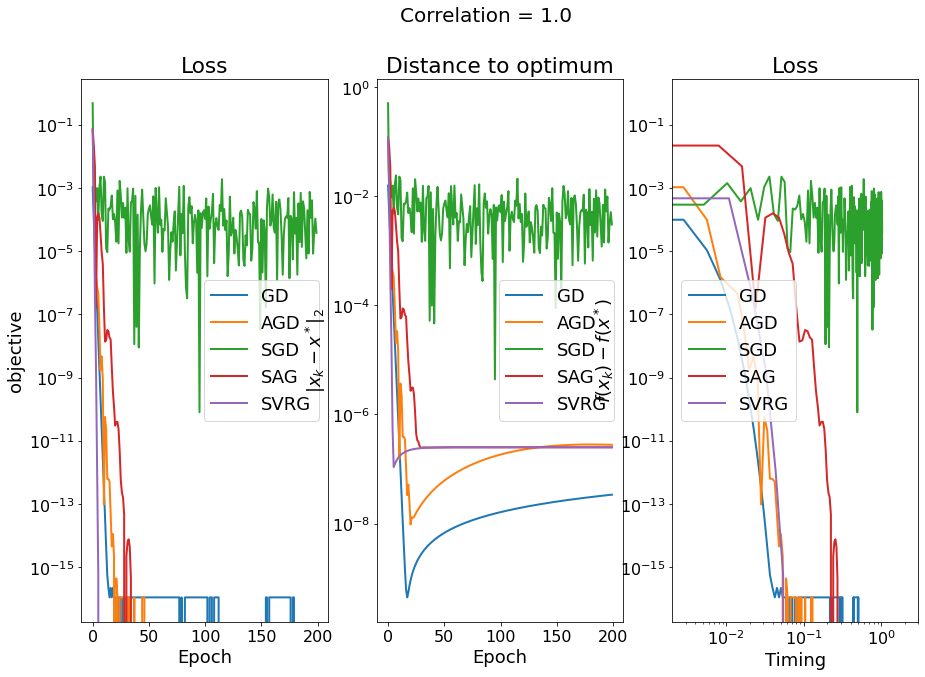

In [ ]:
for corr in  [0.,0.3,0.6,0.8,0.9,1.0] :
  monitors = get_monitors(lbda = 1. / n ** (0.5), corr=corr, model='logreg')
  solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]
  plot_epochs_and_time(monitors, solvers, xscale = 'log', corr = corr)


**Comments :**
- GD and AGD are particularly affected by this correlation change : they peform the best for low correlation 

**Conclusion of this Lab:**

*   Stochastic methods are much faster than deterministic ones, however they are less stable, the evolution of their loss is always shaky.
*   SVRG is by far the most effective method, not only is it the quickest of all, but also the most stable stochastic method. 
*   For both Linear and Logistic Regression, taking $\lambda$ = 1 seems to give better results for all our gradient descents techniques, with the exception of SGD which almost doesn't change. 
*   It is important to note that SAG outperforms SVRG under low ridge regularization for logistic regression
*   We will exclude corr = 1 from the following because it makes the slopes go wild and not follow the general tendencies we observe when slowly increasing the correlation factor.
*   SGD has the least changes when modulating the correlation, and has the worst performances when correlation is low. Starting at corr = 0.8, GD becomes the worst method with SGD being second.
*   For Linear Regression, GD sees the most changes when changing the correlation, at corr = 0, it has the quickest convergence rate, but its performances drop when corr increase, until it becomes the slowest model. 
*   Deterministic models perform worse the more we increase the correlation, however AGD is really unstable when data is uncorrelated.
*   Stochastic methods don't seem to vary much, SVRG remains the best method we have, with AGD not far behind.

